# Task: Classification of covid-19 and non-covid19 CT Scans.

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np
import keras
import pandas as pd
import shutil 
from os import listdir
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split


## **1. Loading the Data**

In [4]:
path="/content/drive/MyDrive/Colab Notebooks/assignment/COVID_19_CT_Data"

In [5]:
train = pd.DataFrame(columns=['imageid','label'])

In [6]:
imageids=[]
labels=[]
path_tr = os.path.join(path,'Train')
path_te = os.path.join(path,'Test')
for dir in os.listdir(path_tr):
  for id in os.listdir(os.path.join(path,'Train',dir)):
    imageids.append(id)
    labels.append(dir) 

print(len(imageids), len(labels))
train.imageid=imageids
train['label']=labels


1400 1400


In [10]:
imageids_COVID = set(train[train.label=='COVID'].imageid.values)
imageids_nonCOVID = set(train[train.label=='non-COVID'].imageid.values)

 Viewing some sample images

In [11]:
def visualize(label, samples):
    if label == 'COVID':
        ids = imageids_COVID
        folder = 'COVID/'
    elif label == 'non-COVID':
        ids = imageids_nonCOVID
        folder = 'non-COVID/'
        
    for id in random.sample(ids, samples):
        img = cv2.imread(path + '/Train/' + folder + id)
        plt.imshow(img)
        plt.title(id)
        plt.show()


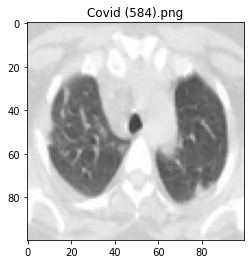

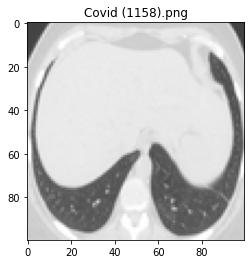

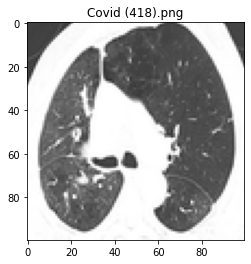

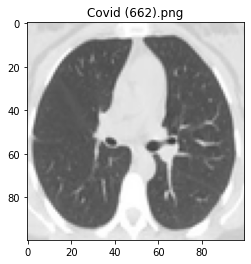

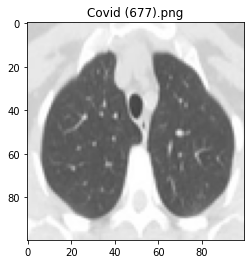

In [14]:
visualize('COVID', 5)

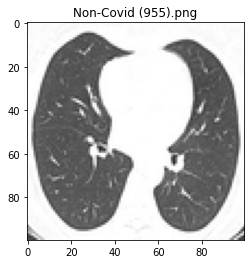

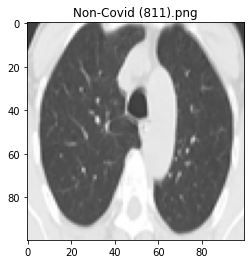

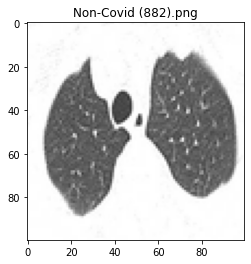

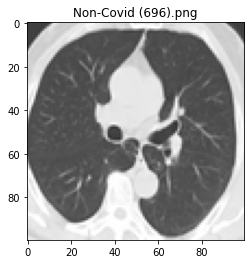

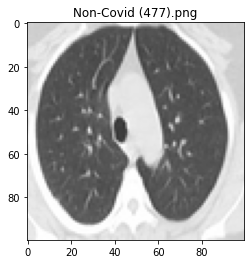

In [15]:
visualize('non-COVID', 5)

# **2. Moving Data to Colab storage**

In [ ]:
for dir in os.listdir(path_tr):
  for id in os.listdir(os.path.join(path,'Train',dir)):
    shutil.copy(os.path.join(path, 'Train', dir, id), 'Train/'+id)

In [ ]:
for dir in os.listdir(path_te):
  for id in os.listdir(os.path.join(path,'Test',dir)):
    shutil.copy(os.path.join(path, 'Test', dir, id), 'Test/'+id)

In [ ]:
test_ids = []
test_labels = []
for id in tqdm(listdir('Test/')):
    test_ids.append(id)
    if id.startswith('Covid'):
        test_labels.append(0) # This is how the data generator perceives COVID - 0, non-COVID - 1
    elif id.startswith('Non-Covid'):
        test_labels.append(1)


In [ ]:
test= pd.DataFrame({'imageid': test_ids, 'label': test_labels})

# **3. Data preparation**

# 3.1 Train Validation Split

In [ ]:
#splitting the data into train 
train_data, val_data = train_test_split(train, test_size=0.15, random_state=42,stratify=train['label'])
print(train_data.shape)
print(val_data.shape)


(1190, 2)
(210, 2)


In [ ]:
train_data['label'].value_counts()

non-COVID    595
COVID        595
Name: label, dtype: int64

In [ ]:
train_ids = train_data.imageid
val_ids = val_data.imageid
train_labels = train_data.label
val_labels = train_data.label

In [ ]:
for id in tqdm(val_ids):
  shutil.move('Train/'+id, 'Validation/'+id)


# 3.2 Data Generator: Generation batches for training

In [ ]:
train_image_gen = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_gen.flow_from_dataframe(train_data, batch_size = baTch_size, x_col='imageid', y_col="label", class_mode="binary", target_size = (100, 100), 
                                                   directory = 'Train',)
val_data_gen = train_image_gen.flow_from_dataframe(val_data, batch_size = baTch_size, x_col='imageid', y_col="label", class_mode="binary", target_size= (100, 100), 
                                                   directory = 'Validation',)
test_data_gen = train_image_gen.flow_from_dataframe(test, batch_size = baTch_size, x_col='imageid', y_col="label", class_mode="binary", target_size = (100, 100), 
                                                   directory = 'Test',)


Found 1190 validated image filenames belonging to 2 classes.
Found 210 validated image filenames belonging to 2 classes.
Found 586 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1400 invalid image filename(s) in x_col="imageid". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## **4. Modeling**

# 4.1. Architecture

In [ ]:

model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16,(3,3),activation='relu', input_shape=(100, 100, 3) ),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),  

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),

      tf.keras.layers.Dense(1, activation='sigmoid')                                                   
])


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 21, 64)       

# 4.2. Training

In [ ]:
model.fit(train_data_gen, verbose = 1, epochs = 60, validation_data = val_data_gen )


Epoch 1/60
38/38 [==============================] - 2s 42ms/step - loss: 0.9056 - accuracy: 0.5160 - val_loss: 0.6827 - val_accuracy: 0.6238
Epoch 2/60
38/38 [==============================] - 1s 35ms/step - loss: 0.6290 - accuracy: 0.6222 - val_loss: 0.6091 - val_accuracy: 0.7429
Epoch 3/60
38/38 [==============================] - 1s 36ms/step - loss: 0.5498 - accuracy: 0.7268 - val_loss: 0.6058 - val_accuracy: 0.6905
Epoch 4/60
38/38 [==============================] - 1s 35ms/step - loss: 0.5221 - accuracy: 0.7453 - val_loss: 0.5821 - val_accuracy: 0.6667
Epoch 5/60
38/38 [==============================] - 1s 34ms/step - loss: 0.4723 - accuracy: 0.7853 - val_loss: 0.5107 - val_accuracy: 0.7619
Epoch 6/60
38/38 [==============================] - 1s 35ms/step - loss: 0.4507 - accuracy: 0.7915 - val_loss: 0.5693 - val_accuracy: 0.6905
Epoch 7/60
38/38 [==============================] - 1s 35ms/step - loss: 0.4903 - accuracy: 0.7495 - val_loss: 0.5198 - val_accuracy: 0.8000
Epoch 8/60
38

In [ ]:
model.evaluate(test_data_gen)

19/19 [==============================] - 0s 22ms/step - loss: 1.6365 - accuracy: 0.6143


[1.636529803276062, 0.6143344640731812]

In [ ]:
test.imageid.value_counts

<bound method IndexOpsMixin.value_counts of 0       Non-Covid (1009).png
1       Non-Covid (1021).png
2       Non-Covid (1018).png
3       Non-Covid (1005).png
4       Non-Covid (1001).png
                ...         
1981          Covid (83).png
1982          Covid (92).png
1983          Covid (91).png
1984          Covid (97).png
1985           Covid (8).png
Name: imageid, Length: 1986, dtype: object>

# 4.3. Predict on test data



In [ ]:
predictions = []
for id in tqdm(test.imageid.values):

    img = cv2.imread('/content/Test/' + id)
    X = np.empty((1,100,100,3),dtype=np.uint8)
    X[0,] = img
    predictions.append(int(model.predict(X)[0][0]))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
report = classification_report(test_labels, predictions)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.52      0.98      0.68       302
           1       0.69      0.04      0.07       284

    accuracy                           0.53       586
   macro avg       0.60      0.51      0.38       586
weighted avg       0.60      0.53      0.39       586



In [ ]:
confusion_matrix(test_labels, predictions)

array([[297,   5],
       [273,  11]])